In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda")

In [4]:
from utils.model import LaplaceBayesianCNNSingleFC

In [ ]:
def fixed_load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [5]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    #with open('datasplit/split_indices.pkl', 'rb') as f:
    #    split = pickle.load(f)
    #    train_dataset = Subset(dataset, split['train'])
    #    test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [6]:
num_classes = 10
bayesian_model = LaplaceBayesianCNNSingleFC(num_classes=num_classes, device=device)

In [7]:
#from pyro.infer.autoguide import AutoDiagonalNormal
#from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import Adam

In [8]:
import torch
from torch import nn
#from torch.distributions import constraints, transforms, Laplace
from pyro.nn import PyroParam
from pyro.infer.autoguide import AutoContinuous
from pyro.infer.autoguide.initialization import init_to_median


class AutoDiagonalLaplace(AutoContinuous):
    """
    This implementation uses a Laplace distribution with diagonal scale to construct
    a guide over the entire latent space, approximating a Laplace posterior.

    Usage::

        guide = AutoDiagonalLaplace(model)
        svi = SVI(model, guide, ...)

    By default, the mean vector is initialized to zero and the scale (b parameter) 
    is initialized to a small positive value.

    :param callable model: A generative model.
    :param callable init_loc_fn: A per-site initialization function.
    :param float init_scale: Initial scale for the standard deviation of each
        latent variable (b parameter of Laplace).
    """

    scale_constraint = torch.distributions.constraints.positive  # scale b > 0 for Laplace

    def __init__(self, model, init_loc_fn=init_to_median, init_scale=0.1):
        if not isinstance(init_scale, float) or not (init_scale > 0):
            raise ValueError("Expected init_scale > 0. but got {}".format(init_scale))
        self._init_scale = init_scale
        super().__init__(model, init_loc_fn=init_loc_fn)

    def _setup_prototype(self, *args, **kwargs):
        super()._setup_prototype(*args, **kwargs)
        self.loc = nn.Parameter(self._init_loc())
        self.scale = PyroParam(
            self.loc.new_full((self.latent_dim,), self._init_scale),
            self.scale_constraint,
        )

    def get_base_dist(self):
        # Base distribution is standard Laplace centered at 0 with scale=1
        return pyro.distributions.Laplace(
            torch.zeros_like(self.loc), 
            torch.ones_like(self.loc)
        ).to_event(1)

    def get_transform(self, *args, **kwargs):
        # Affine transform: x -> loc + scale * x
        # Laplace is closed under affine transforms.
        return transforms.AffineTransform(self.loc, self.scale)

    def get_posterior(self, *args, **kwargs):
        """
        Returns a diagonal Laplace posterior distribution.
        """
        return pyro.distributions.Laplace(self.loc, self.scale).to_event(1)

    def _loc_scale(self, *args, **kwargs):
        return self.loc, self.scale


In [9]:
#guide = pyro.infer.autoguide.AutoLaplaceApproximation(bayesian_model)
#guide = AutoDiagonalNormal(bayesian_model)
#guide = AutoLowRankMultivariateNormal(bayesian_model, rank=10)
guide = AutoDiagonalLaplace(bayesian_model)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

In [10]:
from tqdm import tqdm

In [ ]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")

In [ ]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [ ]:
"""
def train_svi_with_annealing(model, guide, svi, train_loader, num_epochs=10):
    pyro.clear_param_store()
    model.train()
    model.to(device)
    
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        # KL annealing - gradually increase KL weight
        kl_weight = min(1.0, (epoch + 1) / (num_epochs * 0.5))  # Reach full weight at 50% of training
        
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Use weighted ELBO
            def weighted_model(images, labels):
                with pyro.poutine.scale(scale=kl_weight):
                    return model(images, labels)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)

        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs
"""

In [ ]:
"""
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)
losses, accuracies, accuracy_epochs = train_svi(bayesian_model, guide, svi, train_loader, num_epochs=100)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs, accuracies, 'o-')
plt.title('Training Accuracy (Every 10 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
"""

In [ ]:
def train_svi_with_stats(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Lists to store weight and bias statistics
    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats = {'epochs': [], 'means': [], 'stds': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Record weight and bias statistics
            weight_means = []
            weight_stds = []
            bias_means = []
            bias_stds = []
            
            for name, param in pyro.get_param_store().items():
                if 'AutoDiagonalLaplace.loc' in name:
                    weight_means.append(param.mean().item())
                    weight_stds.append(param.std().item())
                elif 'AutoDiagonalLaplace.scale' in name:
                    bias_means.append(param.mean().item())
                    bias_stds.append(param.std().item())
            
            # Store statistics for this epoch
            weight_stats['epochs'].append(epoch + 1)
            weight_stats['means'].append(weight_means)
            weight_stats['stds'].append(weight_stds)
            
            bias_stats['epochs'].append(epoch + 1)
            bias_stats['means'].append(bias_means)
            bias_stats['stds'].append(bias_stds)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats

def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats):
    """Plot training results with weight and bias statistics"""
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)
    
    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Plot 3: Weight Statistics Boxplot
    plt.subplot(2, 2, 3)
    weight_data = []
    weight_labels = []
    
    for i, epoch in enumerate(weight_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = weight_stats['means'][i] + weight_stats['stds'][i]
        weight_data.append(epoch_data)
        weight_labels.append(f'Epoch {epoch}')
    
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.title('LOC Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('LOC Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Bias Statistics Boxplot
    plt.subplot(2, 2, 4)
    bias_data = []
    bias_labels = []
    
    for i, epoch in enumerate(bias_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = bias_stats['means'][i] + bias_stats['stds'][i]
        bias_data.append(epoch_data)
        bias_labels.append(f'Epoch {epoch}')
    
    if bias_data:
        bp2 = plt.boxplot(bias_data, tick_labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    
    plt.title('SCALE Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('SCALE Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import pyro
import matplotlib.pyplot as plt
from tqdm import tqdm
import pyro.poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_svi_with_stats(model, train_loader, num_epochs=10):
    # Create dummy input to wrap model
    dummy_x, _ = next(iter(train_loader))
    dummy_x = dummy_x.to(device)
    wrapped_model = lambda: model(dummy_x)

    # Create guide and SVI
    guide = AutoLaplaceApproximation(wrapped_model)
    optimizer = Adam({"lr": 1e-3})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    pyro.clear_param_store()
    model.train()
    model.to(device)

    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []

    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats = {'epochs': [], 'means': [], 'stds': []}

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)

        # Accuracy every 10 epochs (and first/last)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()

            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Accuracy Epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)

                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)

                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)

                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            epoch_accuracy = correct / total
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)

            # Parameter stats: loc and covariance
            weight_means, weight_stds = [], []
            bias_means, bias_stds = [], []

            for name, param in pyro.get_param_store().items():
                if "AutoLaplaceApproximation.loc" in name and param.ndim > 0:
                    weight_means.append(param.mean().item())
                    weight_stds.append(param.std().item())
                elif "AutoLaplaceApproximation.covariance_matrix" in name and param.ndim > 0:
                    bias_means.append(param.mean().item())
                    bias_stds.append(param.std().item())

            weight_stats['epochs'].append(epoch + 1)
            weight_stats['means'].append(weight_means)
            weight_stats['stds'].append(weight_stds)

            bias_stats['epochs'].append(epoch + 1)
            bias_stats['means'].append(bias_means)
            bias_stats['stds'].append(bias_stds)

            model.train()

            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

    # Compute final Laplace approximation after training
    laplace = guide.laplace_approximation()

    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats, laplace


In [ ]:
def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats):
    """Plot training results with weight and bias statistics"""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(16, 12))

    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)

    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot 3: Weight Stats
    plt.subplot(2, 2, 3)
    weight_data = [m + s for m, s in zip(weight_stats['means'], weight_stats['stds'])]
    weight_labels = [f"Epoch {e}" for e in weight_stats['epochs']]
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    plt.title('LOC Statistics')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 4: Bias Stats
    plt.subplot(2, 2, 4)
    bias_data = [m + s for m, s in zip(bias_stats['means'], bias_stats['stds'])]
    bias_labels = [f"Epoch {e}" for e in bias_stats['epochs']]
    if bias_data:
        bp2 = plt.boxplot(bias_data, labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    plt.title('COVARIANCE Statistics')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [12]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
#bayesian_model.to(device)
#guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with statistics recording
losses, accuracies, accuracy_epochs, weight_stats, bias_stats = train_svi_with_stats(
    bayesian_model, guide, svi, train_loader, num_epochs=100
)

Calculating accuracy for epoch 1: 100%|██████████| 400/400 [00:05<00:00, 71.08it/s] 


Epoch 1 - ELBO Loss: 14624517.9313, Train Accuracy: 35.61%


Epoch 2/100: 100%|██████████| 400/400 [00:17<00:00, 22.31it/s]


Epoch 2 - ELBO Loss: 7577434.9070


Epoch 3/100: 100%|██████████| 400/400 [00:19<00:00, 20.31it/s]


Epoch 3 - ELBO Loss: 5715313.2276


Epoch 4/100: 100%|██████████| 400/400 [00:18<00:00, 21.64it/s]


Epoch 4 - ELBO Loss: 4675426.4081


Epoch 5/100: 100%|██████████| 400/400 [00:18<00:00, 22.10it/s]


Epoch 5 - ELBO Loss: 3974022.2405


Epoch 6/100: 100%|██████████| 400/400 [00:18<00:00, 21.25it/s]


Epoch 6 - ELBO Loss: 3443749.6858


Epoch 7/100: 100%|██████████| 400/400 [00:19<00:00, 20.62it/s]


Epoch 7 - ELBO Loss: 3058090.2465


Epoch 8/100: 100%|██████████| 400/400 [00:18<00:00, 21.67it/s]


Epoch 8 - ELBO Loss: 2757712.1886


Epoch 9/100: 100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


Epoch 9 - ELBO Loss: 2508285.3629


Calculating accuracy for epoch 10: 100%|██████████| 400/400 [00:06<00:00, 63.82it/s] 


Epoch 10 - ELBO Loss: 2305520.8046, Train Accuracy: 58.78%


Epoch 11/100: 100%|██████████| 400/400 [00:18<00:00, 22.01it/s]


Epoch 11 - ELBO Loss: 2108783.2434


Epoch 12/100: 100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


Epoch 12 - ELBO Loss: 1952406.0520


Epoch 13/100: 100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


Epoch 13 - ELBO Loss: 1791837.6272


Epoch 14/100: 100%|██████████| 400/400 [00:18<00:00, 21.89it/s]


Epoch 14 - ELBO Loss: 1667457.4753


Epoch 15/100: 100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


Epoch 15 - ELBO Loss: 1556588.8156


Epoch 16/100: 100%|██████████| 400/400 [00:17<00:00, 22.31it/s]


Epoch 16 - ELBO Loss: 1455698.2274


Epoch 17/100: 100%|██████████| 400/400 [00:18<00:00, 21.17it/s]


Epoch 17 - ELBO Loss: 1356100.5910


Epoch 18/100: 100%|██████████| 400/400 [00:19<00:00, 20.76it/s]


Epoch 18 - ELBO Loss: 1281720.8294


Epoch 19/100: 100%|██████████| 400/400 [00:17<00:00, 22.73it/s]


Epoch 19 - ELBO Loss: 1207758.8625


Calculating accuracy for epoch 20: 100%|██████████| 400/400 [00:06<00:00, 65.09it/s] 


Epoch 20 - ELBO Loss: 1147510.5590, Train Accuracy: 55.39%


Epoch 21/100: 100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


Epoch 21 - ELBO Loss: 1089282.8655


Epoch 22/100: 100%|██████████| 400/400 [00:18<00:00, 21.61it/s]


Epoch 22 - ELBO Loss: 1037327.8906


Epoch 23/100: 100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


Epoch 23 - ELBO Loss: 989816.4915


Epoch 24/100: 100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


Epoch 24 - ELBO Loss: 943348.3255


Epoch 25/100: 100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


Epoch 25 - ELBO Loss: 900991.0378


Epoch 26/100: 100%|██████████| 400/400 [00:18<00:00, 21.88it/s]


Epoch 26 - ELBO Loss: 858179.1384


Epoch 27/100: 100%|██████████| 400/400 [00:19<00:00, 20.87it/s]


Epoch 27 - ELBO Loss: 819674.7924


Epoch 28/100: 100%|██████████| 400/400 [00:18<00:00, 21.25it/s]


Epoch 28 - ELBO Loss: 782242.3170


Epoch 29/100: 100%|██████████| 400/400 [00:18<00:00, 21.89it/s]


Epoch 29 - ELBO Loss: 745699.5949


Calculating accuracy for epoch 30: 100%|██████████| 400/400 [00:05<00:00, 67.62it/s] 


Epoch 30 - ELBO Loss: 711390.6181, Train Accuracy: 18.13%


Epoch 31/100: 100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


Epoch 31 - ELBO Loss: 679561.4584


Epoch 32/100: 100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


Epoch 32 - ELBO Loss: 648747.4371


Epoch 33/100: 100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


Epoch 33 - ELBO Loss: 617800.4042


Epoch 34/100: 100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


Epoch 34 - ELBO Loss: 585107.7086


Epoch 35/100: 100%|██████████| 400/400 [00:19<00:00, 20.88it/s]


Epoch 35 - ELBO Loss: 550290.0103


Epoch 36/100: 100%|██████████| 400/400 [00:19<00:00, 20.63it/s]


Epoch 36 - ELBO Loss: 513511.3352


Epoch 37/100: 100%|██████████| 400/400 [00:18<00:00, 21.67it/s]


Epoch 37 - ELBO Loss: 475051.5866


Epoch 38/100: 100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


Epoch 38 - ELBO Loss: 435599.0154


Epoch 39/100: 100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


Epoch 39 - ELBO Loss: 395691.2666


Calculating accuracy for epoch 40: 100%|██████████| 400/400 [00:05<00:00, 71.54it/s] 


Epoch 40 - ELBO Loss: 356178.4823, Train Accuracy: 10.68%


Epoch 41/100: 100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


Epoch 41 - ELBO Loss: 317814.3683


Epoch 42/100: 100%|██████████| 400/400 [00:18<00:00, 21.33it/s]


Epoch 42 - ELBO Loss: 281755.1597


Epoch 43/100: 100%|██████████| 400/400 [00:18<00:00, 21.46it/s]


Epoch 43 - ELBO Loss: 247951.5464


Epoch 44/100: 100%|██████████| 400/400 [00:18<00:00, 21.98it/s]


Epoch 44 - ELBO Loss: 217976.2848


Epoch 45/100: 100%|██████████| 400/400 [00:18<00:00, 21.66it/s]


Epoch 45 - ELBO Loss: 192237.4914


Epoch 46/100: 100%|██████████| 400/400 [00:19<00:00, 20.75it/s]


Epoch 46 - ELBO Loss: 170273.3313


Epoch 47/100: 100%|██████████| 400/400 [00:18<00:00, 21.52it/s]


Epoch 47 - ELBO Loss: 153337.1662


Epoch 48/100: 100%|██████████| 400/400 [00:22<00:00, 17.91it/s]


Epoch 48 - ELBO Loss: 138717.8958


Epoch 49/100: 100%|██████████| 400/400 [00:21<00:00, 18.98it/s]


Epoch 49 - ELBO Loss: 128459.7670


Calculating accuracy for epoch 50: 100%|██████████| 400/400 [00:06<00:00, 63.56it/s] 


Epoch 50 - ELBO Loss: 120167.1012, Train Accuracy: 10.33%


Epoch 51/100: 100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


Epoch 51 - ELBO Loss: 114127.9907


Epoch 52/100: 100%|██████████| 400/400 [00:18<00:00, 22.00it/s]


Epoch 52 - ELBO Loss: 109539.0352


Epoch 53/100: 100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


Epoch 53 - ELBO Loss: 105511.0563


Epoch 54/100: 100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


Epoch 54 - ELBO Loss: 102661.0888


Epoch 55/100: 100%|██████████| 400/400 [00:18<00:00, 22.09it/s]


Epoch 55 - ELBO Loss: 100318.8075


Epoch 56/100: 100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


Epoch 56 - ELBO Loss: 98734.9937


Epoch 57/100: 100%|██████████| 400/400 [00:19<00:00, 20.47it/s]


Epoch 57 - ELBO Loss: 95952.9154


Epoch 58/100: 100%|██████████| 400/400 [00:18<00:00, 21.29it/s]


Epoch 58 - ELBO Loss: 93670.3925


Epoch 59/100: 100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


Epoch 59 - ELBO Loss: 92423.3835


Calculating accuracy for epoch 60: 100%|██████████| 400/400 [00:05<00:00, 68.77it/s] 


Epoch 60 - ELBO Loss: 89984.5905, Train Accuracy: 10.42%


Epoch 61/100: 100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


Epoch 61 - ELBO Loss: 89008.1241


Epoch 62/100: 100%|██████████| 400/400 [00:17<00:00, 22.32it/s]


Epoch 62 - ELBO Loss: 87212.2538


Epoch 63/100: 100%|██████████| 400/400 [00:18<00:00, 21.20it/s]


Epoch 63 - ELBO Loss: 85283.8814


Epoch 64/100: 100%|██████████| 400/400 [00:19<00:00, 20.54it/s]


Epoch 64 - ELBO Loss: 84054.0517


Epoch 65/100: 100%|██████████| 400/400 [00:18<00:00, 21.70it/s]


Epoch 65 - ELBO Loss: 83359.5150


Epoch 66/100: 100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


Epoch 66 - ELBO Loss: 81437.1912


Epoch 67/100: 100%|██████████| 400/400 [00:20<00:00, 19.24it/s]


Epoch 67 - ELBO Loss: 80088.8018


Epoch 68/100: 100%|██████████| 400/400 [00:18<00:00, 21.87it/s]


Epoch 68 - ELBO Loss: 78489.6494


Epoch 69/100: 100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


Epoch 69 - ELBO Loss: 77597.0786


Calculating accuracy for epoch 70: 100%|██████████| 400/400 [00:05<00:00, 69.39it/s] 


Epoch 70 - ELBO Loss: 76477.3932, Train Accuracy: 10.88%


Epoch 71/100: 100%|██████████| 400/400 [00:20<00:00, 19.20it/s]


Epoch 71 - ELBO Loss: 76270.6848


Epoch 72/100: 100%|██████████| 400/400 [00:20<00:00, 19.96it/s]


Epoch 72 - ELBO Loss: 73660.8118


Epoch 73/100: 100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


Epoch 73 - ELBO Loss: 73098.5610


Epoch 74/100: 100%|██████████| 400/400 [00:19<00:00, 20.47it/s]


Epoch 74 - ELBO Loss: 71562.5725


Epoch 75/100: 100%|██████████| 400/400 [00:19<00:00, 20.63it/s]


Epoch 75 - ELBO Loss: 70778.7495


Epoch 76/100: 100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


Epoch 76 - ELBO Loss: 69411.1695


Epoch 77/100: 100%|██████████| 400/400 [00:18<00:00, 21.72it/s]


Epoch 77 - ELBO Loss: 71175.2295


Epoch 78/100: 100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


Epoch 78 - ELBO Loss: 68664.3073


Epoch 79/100: 100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


Epoch 79 - ELBO Loss: 67965.4922


Calculating accuracy for epoch 80: 100%|██████████| 400/400 [00:06<00:00, 66.34it/s] 


Epoch 80 - ELBO Loss: 65467.5212, Train Accuracy: 10.31%


Epoch 81/100: 100%|██████████| 400/400 [00:18<00:00, 22.20it/s]


Epoch 81 - ELBO Loss: 65803.2064


Epoch 82/100: 100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


Epoch 82 - ELBO Loss: 64594.3250


Epoch 83/100: 100%|██████████| 400/400 [00:18<00:00, 21.91it/s]


Epoch 83 - ELBO Loss: 63995.1542


Epoch 84/100: 100%|██████████| 400/400 [00:19<00:00, 20.21it/s]


Epoch 84 - ELBO Loss: 62767.9039


Epoch 85/100: 100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


Epoch 85 - ELBO Loss: 61687.6928


Epoch 86/100: 100%|██████████| 400/400 [00:19<00:00, 20.86it/s]


Epoch 86 - ELBO Loss: 60636.9598


Epoch 87/100: 100%|██████████| 400/400 [00:17<00:00, 22.33it/s]


Epoch 87 - ELBO Loss: 60008.7381


Epoch 88/100: 100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


Epoch 88 - ELBO Loss: 59667.9294


Epoch 89/100: 100%|██████████| 400/400 [00:19<00:00, 20.88it/s]


Epoch 89 - ELBO Loss: 59054.8203


Calculating accuracy for epoch 90: 100%|██████████| 400/400 [00:05<00:00, 68.60it/s] 


Epoch 90 - ELBO Loss: 58045.0756, Train Accuracy: 10.34%


Epoch 91/100: 100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


Epoch 91 - ELBO Loss: 57394.2399


Epoch 92/100: 100%|██████████| 400/400 [00:18<00:00, 21.61it/s]


Epoch 92 - ELBO Loss: 57287.7657


Epoch 93/100: 100%|██████████| 400/400 [00:20<00:00, 19.77it/s]


Epoch 93 - ELBO Loss: 58623.5699


Epoch 94/100: 100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


Epoch 94 - ELBO Loss: 55767.7788


Epoch 95/100: 100%|██████████| 400/400 [00:18<00:00, 21.61it/s]


Epoch 95 - ELBO Loss: 55982.1905


Epoch 96/100: 100%|██████████| 400/400 [00:18<00:00, 22.01it/s]


Epoch 96 - ELBO Loss: 54091.9574


Epoch 97/100: 100%|██████████| 400/400 [00:20<00:00, 19.99it/s]


Epoch 97 - ELBO Loss: 53822.0562


Epoch 98/100: 100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


Epoch 98 - ELBO Loss: 53002.5815


Epoch 99/100: 100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


Epoch 99 - ELBO Loss: 52733.8799


Calculating accuracy for epoch 100: 100%|██████████| 400/400 [00:06<00:00, 64.20it/s] 

Epoch 100 - ELBO Loss: 51524.5501, Train Accuracy: 10.09%


C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_34592\3240986501.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)


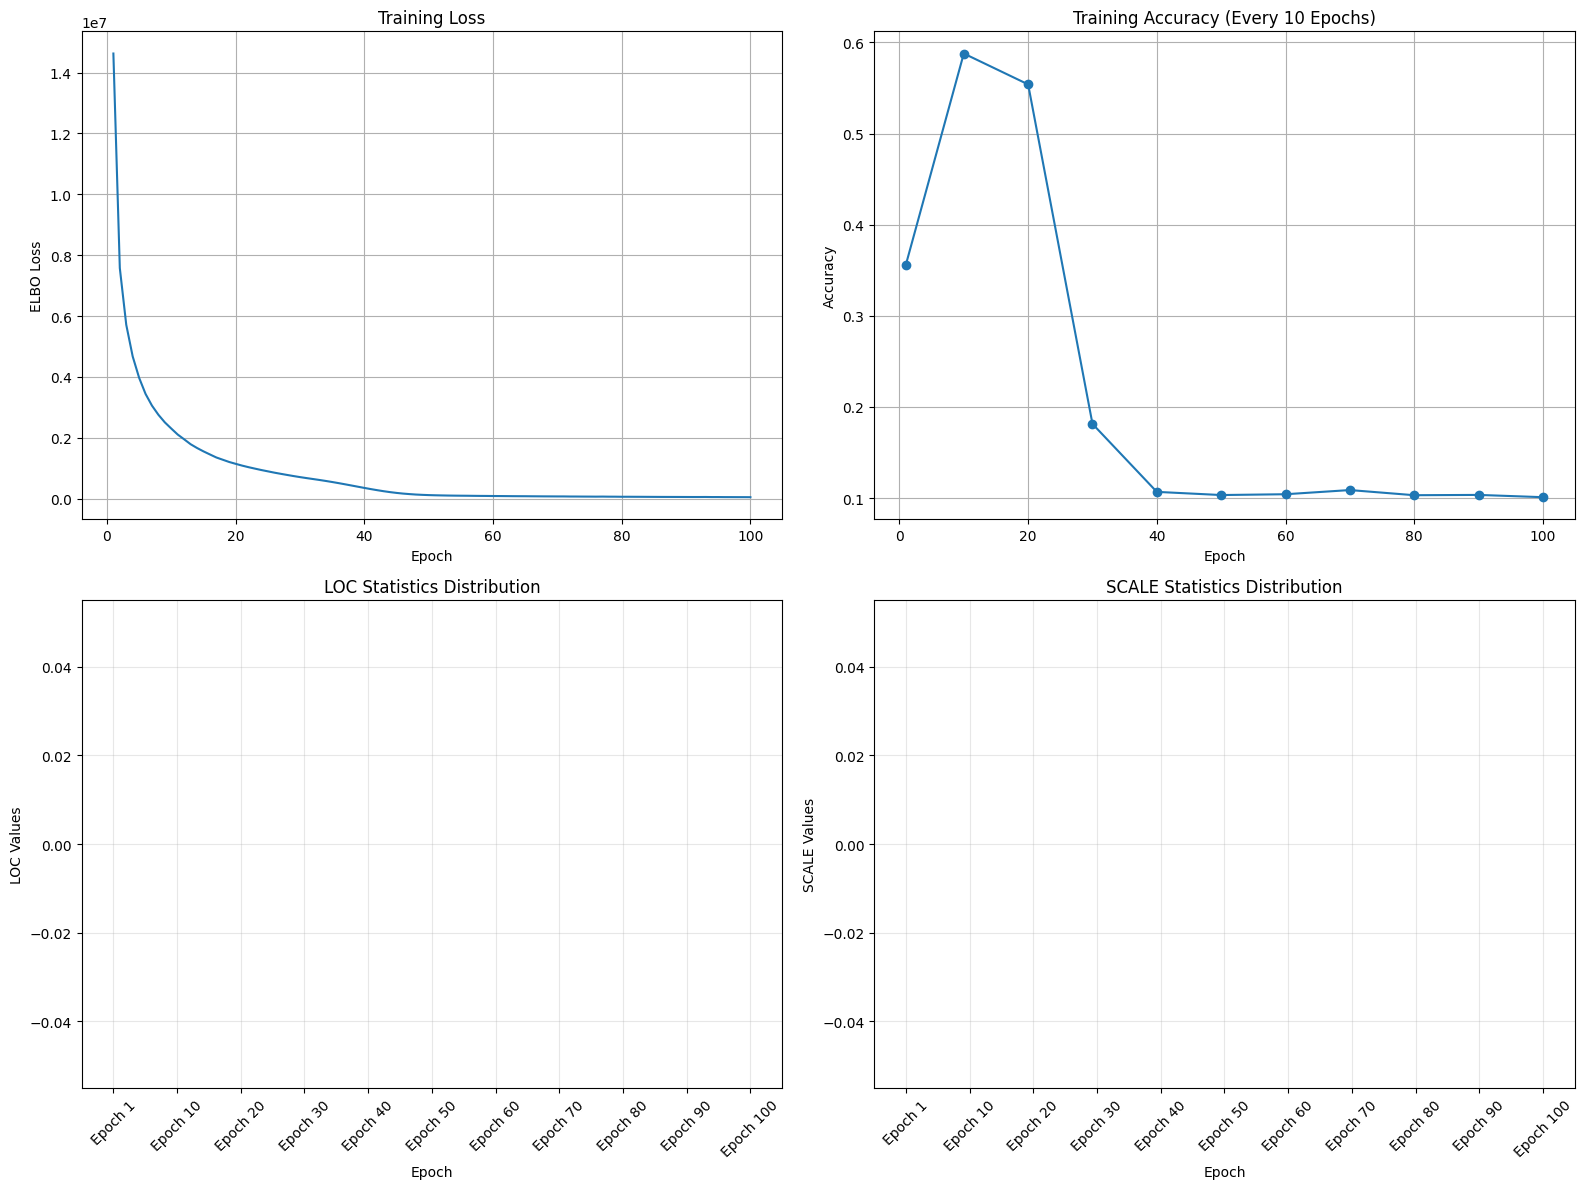

In [13]:
# Plot all results including weight and bias statistics
plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats)

In [ ]:
weight_stats #turns to df

In [ ]:
bias_stats

In [ ]:
accuracies

In [ ]:
weight_means = []
weight_stds = []
bias_means = []
bias_stds = []

In [15]:
for name, param in pyro.get_param_store().items():
    print(f"Parameter: {name}, Mean: {param.mean().item()}, Std: {param.std().item()}")
    if 'AutoDiagonalNormal.loc' in name:
        weight_means.append(param.mean().item())
        weight_stds.append(param.std().item())
    elif 'AutoDiagonalNormal.scale' in name:
        bias_means.append(param.mean().item())
        bias_stds.append(param.std().item())

Parameter: AutoDiagonalLaplace.loc, Mean: -0.22667573392391205, Std: 1.6305941343307495
Parameter: AutoDiagonalLaplace.scale, Mean: 8.2422456741333, Std: 3.257894992828369


In [ ]:
weight_means

In [ ]:
#pyro.clear_param_store()

# Ensure model and guide are on the correct device
#bayesian_model.to(device)
#guide.to(device)

#train_loader, test_loader = load_data(batch_size=54)
#train_svi(bayesian_model, guide, svi, train_loader, num_epochs=0)

In [14]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch_laplace_custom.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide_laplace_custom.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch_laplace_custom.pkl'
pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
STOPDULUDAH

In [ ]:
import numpy as np

In [16]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, loader_of_interest, num_samples=10):
    model.eval()
    guide.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader_of_interest, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace(images)
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [17]:
train_labels, train_predictions = predict_data(bayesian_model, train_loader, num_samples=10)

Evaluating: 100%|██████████| 400/400 [00:45<00:00,  8.80it/s]


In [18]:
train_cm = confusion_matrix(train_labels, train_predictions)

In [19]:
#print accuracy from confusion matrix
train_accuracy = np.trace(train_cm) / np.sum(train_cm)
print(f"Train accuracy from confusion matrix: {train_accuracy * 100:.6f}%")

Train accuracy from confusion matrix: 10.921296%


In [20]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


In [ ]:
cm = confusion_matrix(all_labels, all_predictions)

In [ ]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

In [ ]:
# print pyro parameters
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape} - {value.mean().item():.4f} ± {value.std().item():.4f}")

60.092593% for the 10 epoch

In [ ]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [ ]:
# save the model
#model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
#torch.save(bayesian_model.state_dict(), model_path)

# save the guide
#guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
#torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
#pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'
#pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
kataguediemdeh

In [ ]:
def train_svi_early_save(model, guide, svi, train_loader, num_epochs=10, patience=3, min_delta=0.001):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Early stopping variables
    best_accuracy = 0.0
    best_epoch = 0
    patience_counter = 0
    best_model_state = None
    best_guide_state = None
    best_pyro_params = None
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Check for improvement
            if epoch_accuracy > best_accuracy + min_delta:
                best_accuracy = epoch_accuracy
                best_epoch = epoch + 1
                patience_counter = 0
                
                # Save best model states
                best_model_state = model.state_dict().copy()
                best_guide_state = guide.state_dict().copy()
                best_pyro_params = pyro.get_param_store().get_state().copy()
                
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% *** NEW BEST ***")
            else:
                patience_counter += 1
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% (Best: {best_accuracy*100:.2f}% at epoch {best_epoch})")
                
                # Early stopping check
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered! No improvement for {patience} evaluations.")
                    print(f"Best accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")
                    
                    # Restore best model
                    model.load_state_dict(best_model_state)
                    guide.load_state_dict(best_guide_state)
                    pyro.get_param_store().set_state(best_pyro_params)
                    
                    break
            
            model.train()  # Set back to training mode
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # If training completed without early stopping, still restore best model
    if patience_counter < patience and best_model_state is not None:
        print(f"\nTraining completed. Restoring best model from epoch {best_epoch} (accuracy: {best_accuracy*100:.2f}%)")
        model.load_state_dict(best_model_state)
        guide.load_state_dict(best_guide_state)
        pyro.get_param_store().set_state(best_pyro_params)
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, best_epoch, best_accuracy

In [ ]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with early stopping
losses, accuracies, accuracy_epochs, best_epoch, best_accuracy = train_svi(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100, 
    patience=3,  # Stop if no improvement for 3 accuracy evaluations (30 epochs)
    min_delta=0.001  # Minimum improvement threshold (0.1%)
)

print(f"\nFinal Results:")
print(f"Best training accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs, accuracies, 'o-')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.axhline(y=best_accuracy, color='red', linestyle=':', alpha=0.7)
plt.title('Training Accuracy (Every 10 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os

In [ ]:
def train_svi_with_tensorboard(model, guide, svi, train_loader, num_epochs=10, log_dir='runs/bayesian_cnn'):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Log loss to TensorBoard every epoch
        writer.add_scalar('Loss/ELBO', avg_loss, epoch + 1)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Log accuracy to TensorBoard
            writer.add_scalar('Accuracy/Train', epoch_accuracy, epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # Close the writer
    writer.close()
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

Feature TODO:
1. Record loss after each epoch
2. Send result to GPU

## AutoDiagonalNormal guide

In [ ]:
# Make sure the guide is in eval mode
guide.eval()

# Get the Laplace approximation
with torch.no_grad():
    try:
        new_guide = guide.laplace_approximation()
        print("Laplace approximation successful!")
    except Exception as e:
        print(f"Error: {e}")
        print("Guide may not be properly initialized or trained")

In [ ]:
dummy_x, dummy_y = next(iter(train_loader))
dummy_x = dummy_x.to(device)
wrapped_model = lambda: bayesian_model(dummy_x)

In [ ]:
# Create the guide
#guide = pyro.infer.autoguide.AutoLaplaceApproximation(wrapped_model)

# Train the guide (with real data, using SVI)
#svi = pyro.infer.SVI(bayesian_model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

# After training, extract the Laplace approximation
#laplace = guide.laplace_approximation()

In [ ]:
# After training, extract the Laplace approximation
laplace = guide.laplace_approximation()

In [ ]:
wrapped_model